In [2]:
"""
import sys
!{sys.executable} -m pip install openpyxl
#"""

'\nimport sys\n!{sys.executable} -m pip install openpyxl\n#'

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import re
import nltk

st = stopwords.words('english')
stemmer = PorterStemmer()

def loadDataAsDataFrame(f_path):
    '''
        Given a path, loads a data set and puts it into a dataframe
        - simplified mechanism
    '''
    df = pd.read_csv(f_path)
    return df


def preprocess_text(raw_text):

    # Replace/remove username
    raw_text = re.sub('(@[A-Za-z0-9\_]+)', '@username_', raw_text)
    #stemming and lowercasing
    words=[]
    for w in raw_text.lower().split():
        if not w in st and not w in ['.',',', '[', ']', '(', ')']:
            words.append(w)
            
    return (" ".join(words))

In [4]:
#Load the data
f_path = 'pdfalls.csv'
data = loadDataAsDataFrame(f_path)

texts = data['fall_description']
classes = data['fall_class']
ids = data['record_id']

#PREPROCESS THE DATA
texts_preprocessed=[preprocess_text(txt) for txt in texts]
data['preprocessed_texts']=texts_preprocessed

In [5]:
#used to convert our data text into a formal readable by metamaplite

def csvTosldiwi(dataframe, outputFileName, feature):
    file1 = open(outputFileName, "w", encoding="utf-8")  
        
    for i, row in dataframe.iterrows():

        #title=(row['Document'], row['Sentence'])
        title=str(i)
        text=row[feature]
        output=title + "|" + text + "\n"

        file1.write(output) 
    
    file1.close() 
    
#csvTosldiwi(data, "pdfallssldiwi.txt", 'fall_description')
#csvTosldiwi(data, "pdfallsLocsldiwi.txt", 'fall_location')

In [6]:
#we take the sldiwi file, process it with metamap in a separate script,
#then load it back into this program here:

mmiLocDF=pd.read_csv("pdfallsLocsmmi.txt", sep='|', header=None)
mmiLocDF.columns=['Title', "1", "Score", "3", "cnum", "4", "5", "6", "7", "8"]

mmiDF=pd.read_csv("pdfallsmmi.txt", sep='|', header=None)
mmiDF.columns=['Title', "1", "Score", "3", "cnum", "4", "5", "6", "7", "8"]
mmiDF[mmiDF['Score']>=1]

,Title,1,Score,3,cnum,4,5,6,7,8
0,88,MMI,3.68,Falls,C0085639,[fndg],"Fall-text-23-""fall""-NN-0,""Falls""-text-0-""falls...",text,140/4;247/5,N06.850.135.122
1,88,MMI,1.84,Accidental Falls,C0000921,[inpo],"Falls-text-0-""falls""-NNS-0",text,247/5,N06.850.135.122
2,88,MMI,1.84,Hand,C0018563,[bpoc],"Hands-text-5-""hands""-NNS-0",text,100/5,A01.378.800.667
3,88,MMI,1.84,Stomach,C0038351,[bpoc],"Stomach-text-0-""stomach""-NN-0",text,67/7,A03.556.875.875
4,88,MMI,1.38,Stomach Diseases,C0038354,[dsyn],"Stomach-text-0-""stomach""-NN-0",text,67/7,C06.405.748
...,...,...,...,...,...,...,...,...,...,...
2747,86,MMI,1.84,Feces,C0015733,[bdsu],"Stool-text-0-""stool""-NN-0,""Stool""-text-0-""stoo...",text,110/5;193/5,A12.459
2748,86,MMI,1.84,Shoulder,C0037004,[blor],"Shoulder-text-21-""shoulder""-NN-0",text,172/8,A01.378.800.750
2749,86,MMI,1.38,Clothing,C0009072,[mnob],"clothes-text-0-""clothes""-NNS-0",text,18/7,J01.637.215
2756,87,MMI,12.43,S-adenosylmethionine,C0036002,"[bacs, aapp, phsu]","SAMe-text-0-""same""-JJ-0",text,0/4,D03.633.100.759.590.138.264;D12.125.166.676.18...


In [7]:
#add the metamap data to our current dataframe

def getCnumsForDF(df, mmidf):
    allCnums=[]
    
    for i, row in df.iterrows():
        title = (i)
        mmiRows=mmidf[(mmidf['Title']==title) & (mmidf['Score']>=1)]
        cnumList = mmiRows['cnum'].tolist()
        
        cnums=''
        for cnum in cnumList: 
            cnums+=cnum + " "
        allCnums.append(cnums)
        
    return allCnums

dataCnums=getCnumsForDF(data, mmiDF)
data['CNums']=dataCnums

dataLocCnums=getCnumsForDF(data, mmiLocDF)
data['LocCNums']=dataLocCnums

In [8]:
#transform target varaibles into "CoM" and "Other" only

yRaw = data['fall_class']
yFeature=[]
for y in yRaw:
    if y=='CoM':
        yFeature.append(y)
    else:
        yFeature.append('Other')

data['target']=yFeature

In [9]:
data

,record_id,age,female,duration,fall_class,fall_study_day,fall_location,fall_description,preprocessed_texts,CNums,LocCNums,target
0,110,82,Male,7.2,CoM,20,Home-kitchen,Home-kitchen. standing and turning forward too...,home-kitchen. standing turning forward quickly,,,CoM
1,110,82,Male,7.2,CoM,30,living room,standing and turning,standing turning,,,CoM
2,110,82,Male,7.2,CoM,70,kitchen,standing up. turned too fast. landed face down...,standing up. turned fast. landed face down. tu...,C0015663 C0242821 C1140621 C0015450,,CoM
3,110,82,Male,7.2,CoM,130,Kitchen,I had a small bottle in my right hand. I was u...,small bottle right hand. using left hand guide...,C0043016 C0009932 C4321304 C0013769 C0018563 C...,,CoM
4,110,82,Male,7.2,CoM,228,YMCA,Turned around and reached for the walker. Turn...,turned around reached walker. turned fast took...,C0015663 C0025219 C0456387 C0008902 C0220870 C...,,CoM
...,...,...,...,...,...,...,...,...,...,...,...,...
111,64,61,Female,4.9,BoS,392,outside,Was loading things from grocery cart into car....,loading things grocery cart car. tripped trail...,C0406810 C0003798 C0004381 C1738809 C1505163 C...,,Other
112,64,61,Female,4.9,CoM,394,hotel bathroom,"Stood up after using toilet, toilet was very l...","stood using toilet, toilet low. lost balance, ...",C1140607 C0036588 C0085732 C0222762,C0556989 C0040364,CoM
113,64,61,Female,4.9,CoM,456,home,Was walking from the kitchen into the living r...,"walking kitchen living room, lost balance carr...",C0015663 C0036588,,CoM
114,66,60,Male,2.4,BoS,374,Indian Trail - Chattahoochee River,Walking - Hiking. Tripped on an exposed root. ...,walking - hiking. tripped exposed root. [lande...,C0004600,C0385242 C0337050 C1143949,Other


In [10]:
data.iloc[3]['fall_description']

'I had a small bottle in my right hand. I was using my left hand to guide the walker.  Did not have control of the walker and should not have anything other than my hands on the walker at all times. knees! no serious injuries! just something on elbow. turn around and push myself up while holding on to the walker'

In [11]:
from collections import Counter

Counter(data['target'])

Counter({'CoM': 81, 'Other': 35})

In [12]:

word_clusters = {}

def loadwordclusters():
    infile = open('./50mpaths2',  "r", encoding="utf-8")
    for line in infile:
        items = str.strip(line).split()
        class_ = items[0]
        term = items[1]
        word_clusters[term] = class_
    return word_clusters

def getclusterfeatures(sent):
    sent = sent.lower()
    terms = nltk.word_tokenize(sent)
    cluster_string = ''
    for t in terms:
        if t in word_clusters.keys():
                cluster_string += 'clust_' + word_clusters[t] + '_clust '
    return str.strip(cluster_string)

loadwordclusters()

class myVectorizer():
    def __init__(self):
        self.textVectorizer=CountVectorizer(ngram_range=(1, 3), max_features=10000)
        self.clustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
        self.cnumclustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
        self.loccnumClusterVectorizer= CountVectorizer(ngram_range=(1,1), max_features=1000)
        
        #for normaluzation
        self.maxs={}
        self.mins={}
    
    def fit(self, rows, y=None):
        
        #fall description
        unprocessedTexts=rows['fall_description']
        
        texts_preprocessed = []
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
            
        allcnums=[]
        allCNumLists=rows['CNums']
        for cnumList in allCNumLists:
            allcnums.append(cnumList)
        
        self.textVectorizer.fit(texts_preprocessed)
        self.clustervectorizer.fit(clusters)
        self.cnumclustervectorizer.fit(allcnums)  
        
        #fall location
        allLoccnums=[]
        allLocCNumLists=rows['LocCNums']
        for cnumList in allLocCNumLists:
            allLoccnums.append(cnumList)
            
        self.loccnumClusterVectorizer.fit(allLoccnums)  
        
        
        #get ready to normalize all the other features
        for feature in training_rows.columns:
            values=training_rows[feature]
            featureType=type(values[0])

            if not featureType==str or featureType==int:
                self.maxs[feature]=max(values)
                self.mins[feature]=min(values)
            
        
    
    def transform(self, rows):
        unprocessedTexts=rows['fall_description']
        texts_preprocessed = []
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
        
        data_vectors = self.textVectorizer.transform(texts_preprocessed).toarray()
        cluster_vectors = self.clustervectorizer.transform(clusters).toarray()

        data_vectors = np.concatenate((data_vectors, cluster_vectors), axis=1)
        
        allcnums=rows['CNums']
        cnum_cluster_vectors = self.cnumclustervectorizer.transform(allcnums).toarray()
        allloccnums=rows['LocCNums']
        loc_cnum_cluster_vectors = self.loccnumClusterVectorizer.transform(allloccnums).toarray()
        
        data_vectors = np.concatenate((data_vectors, cnum_cluster_vectors), axis=1)
        data_vectors = np.concatenate((data_vectors, loc_cnum_cluster_vectors), axis=1)

        
        #tack on all the other numeric features
        for feature in ['duration',]:
            values=rows[feature]
            normValues = np.array([getNormalizedList(values, self.maxs[feature], self.mins[feature])])
            data_vectors=np.concatenate((data_vectors, normValues.T), axis=1)
        
        return data_vectors
    
    def fit_transform(self, rows, y=None):
        self.fit(rows)
        return self.transform(rows)


In [13]:
def grid_search_hyperparam_space(params, pipeline, folds, training_texts, training_classes):#folds, x_train, y_train, x_validation, y_validation):
        grid_search = GridSearchCV(estimator=pipeline, param_grid=params, refit=True, cv=folds, return_train_score=False, scoring='f1_macro',n_jobs=-1)
        grid_search.fit(training_texts, training_classes)
        return grid_search

## Split the data

In [14]:
from sklearn.model_selection import train_test_split

training_set_size = int(0.8*len(data))

X=data
y=data['target'].tolist()

training_rows, test_rows, training_classes, test_classes = train_test_split(
    X, y, train_size=training_set_size, random_state=42069)


In [15]:

def normalize(value, maxOfList, minOfList):
    return (value - minOfList) / (maxOfList - minOfList)
    
def getNormalizedList(values, maxOfList, minOfList):
    ret = []
    for value in values:
        ret.append(normalize(value, maxOfList, minOfList))
        
    return ret  

'\nmaxs={}\nmins={}\n\nfor feature in training_rows.columns:\n    #print(feature)\n    values=training_rows[feature]\n    featureType=type(values[0])\n    \n    if not featureType==str or featureType==int:\n        maxs[feature]=max(values)\n        mins[feature]=min(values)\n        \nprint(maxs)\nprint(mins)\n\nfor feature in [\'duration\', \'age\']:\n    print(feature)\n    values=training_rows[feature]\n    normValues = getNormalizedList(values, maxs[feature], mins[feature])\n    for i in range(len(values)):\n        print(values[i], "\t", normValues[i])\n    print("*********************")\n'

In [16]:
from sklearn.metrics import precision_recall_fscore_support as prf1
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1

## GNB baseline


In [17]:

vectorizer = myVectorizer()

#CLASSIFIER
gnb_classifier = GaussianNB()
grid_params = {}

#SIMPLE PIPELINE
pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',gnb_classifier)])

#SEARCH HYPERPARAMETERS
folds = 5
grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

#CLASSIFY AND EVALUATE 
predictions_test = grid.predict(test_rows)
print('Performance on held-out test set ... :')

print(accuracy_score(predictions_test,test_classes))

Performance on held-out test set ... :
0.7083333333333334


# Optimize Parameters

## SVM classifier

Best hyperparameters:
{'svm_classifier__C': 0.25, 'svm_classifier__kernel': 'linear'}

In [18]:
vectorizer = myVectorizer()

#CLASSIFIER
svm_classifier = svm.SVC(gamma='scale')

#SIMPLE PIPELINE
pipeline = Pipeline(steps = [('vec',vectorizer),('svm_classifier',svm_classifier)])

grid_params = {
     'svm_classifier__C': [0.25, .5,1,2,4,8,16,32,64,128],
     'svm_classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

#SEARCH HYPERPARAMETERS
folds = 5
grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

print('Best hyperparameters:')
print(grid.best_params_)

print('All scores:')
#all_means = grid.cv_results_['mean_test_score']
#all_standard_devs = grid.cv_results_['std_test_score']
#all_params = grid.cv_results_['params']
#for mean, std, params in zip(all_means, all_standard_devs, all_params ):
#    print('Mean:',mean, 'Standard deviation:', std, 'Hyperparameters:',  params)

c_ = grid.best_params_['svm_classifier__C']
kernel_ = grid.best_params_['svm_classifier__kernel']

#CLASSIFY AND EVALUATE 
predictions_test = grid.predict(test_rows)
print('Performance on held-out test set ... :')

print(accuracy_score(predictions_test,test_classes))

Best hyperparameters:
{'svm_classifier__C': 0.25, 'svm_classifier__kernel': 'linear'}
All scores:
Performance on held-out test set ... :
0.6666666666666666


## Random Forest

Best hyperparameters:
{'classifier__n_estimators': 30}



In [19]:
vectorizer = myVectorizer()

rf = RandomForestClassifier()

#SIMPLE PIPELINE
pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',rf)])
#pipeline ensures vectorization happens in each fold of grid search 
#(you could code the entire process manually for more flexibility)

grid_params = {
     'classifier__n_estimators': np.arange(5,60,5)
}

#SEARCH HYPERPARAMETERS
folds = 5
grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

print('Best hyperparameters:')
print(grid.best_params_)

print('Optimal n found:', grid.best_params_['classifier__n_estimators'])

#CLASSIFY AND EVALUATE 
predictions_test = grid.predict(test_rows)
print('Performance on held-out test set ... :')

print(accuracy_score(predictions_test,test_classes))


Best hyperparameters:
{'classifier__n_estimators': 25}
Optimal n found: 25
Performance on held-out test set ... :
0.7083333333333334


## KNN

Best hyperparameters:
{'classifier__n_neighbors': 1}



In [20]:
from sklearn.neighbors import KNeighborsClassifier

vectorizer = myVectorizer()

clf= KNeighborsClassifier()

#SIMPLE PIPELINE
pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',clf)])
#pipeline ensures vectorization happens in each fold of grid search 
#(you could code the entire process manually for more flexibility)

grid_params = {
     'classifier__n_neighbors': np.arange(1,20,1),
}

#SEARCH HYPERPARAMETERS
folds = 5
grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

print('Best hyperparameters:')
print(grid.best_params_)

#CLASSIFY AND EVALUATE 
predictions_test = grid.predict(test_rows)
print('Performance on held-out test set ... :')

print(accuracy_score(predictions_test,test_classes))

Best hyperparameters:
{'classifier__n_neighbors': 4}
Performance on held-out test set ... :
0.7083333333333334


## Neural Network

Is it really data science if there isn't a neural network somewhere?

Best hyperparameters:
{'classifier__hidden_layer_sizes': (71,)}


In [21]:
from sklearn.neural_network import MLPClassifier

vectorizer = myVectorizer()

clf= MLPClassifier()

#SIMPLE PIPELINE
pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',clf)])
#pipeline ensures vectorization happens in each fold of grid search 
#(you could code the entire process manually for more flexibility)

#we'll just use one hidden layer
layerParams=[]
for n in range(1,101, 10):
    layerParams.append(tuple([n]))
    
grid_params = {
     'classifier__hidden_layer_sizes': layerParams,
}

#SEARCH HYPERPARAMETERS
folds = 5
grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

print('Best hyperparameters:')
print(grid.best_params_)

#CLASSIFY AND EVALUATE 
predictions_test = grid.predict(test_rows)
print('Performance on held-out test set ... :')

print(accuracy_score(predictions_test,test_classes))

Best hyperparameters:
{'classifier__hidden_layer_sizes': (71,)}
Performance on held-out test set ... :
0.7083333333333334


## Voting Classifier
That combines all of the classifiers above

In [22]:
gnb = GaussianNB()
svmc = svm.SVC(C=0.25, kernel='linear', gamma='scale', probability=True)
rf = RandomForestClassifier(n_estimators=30)
knn=KNeighborsClassifier(n_neighbors=1)
nn=MLPClassifier(hidden_layer_sizes=(71,))

en=VotingClassifier(estimators=[('SVM', svmc), ('RF', rf), 
                                ("KNN", knn), ("NN", nn)])

vectorizer = myVectorizer()

#SIMPLE PIPELINE
pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',en)])
#pipeline ensures vectorization happens in each fold of grid search 
#(you could code the entire process manually for more flexibility)
    
grid_params = {
     'classifier__voting': ['soft', 'hard']
}

#SEARCH HYPERPARAMETERS
folds = 5
grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

print('Best hyperparameters:')
print(grid.best_params_)

#CLASSIFY AND EVALUATE 
predictions_test = grid.predict(test_rows)
print('Performance on held-out test set ... :')

print(accuracy_score(predictions_test,test_classes))

Best hyperparameters:
{'classifier__voting': 'soft'}
Performance on held-out test set ... :
0.7083333333333334


## Now evaluate them all

In [38]:
from sklearn.metrics import confusion_matrix
import random

"""
Confusion matrix whose i-th row and j-th column entry indicates the number of samples 
with true label being i-th class and prediced label being j-th class.
"""

gnb = GaussianNB()
svmc = svm.SVC(C=0.25, kernel='linear', gamma='scale', probability=True)
rf = RandomForestClassifier(n_estimators=30)
knn=KNeighborsClassifier(n_neighbors=1)
nn=MLPClassifier(hidden_layer_sizes=(71,))
en=VotingClassifier(estimators=[('SVM', svmc), ('RF', rf), 
                                ("KNN", knn), ("NN", nn)], 
                                      voting='soft')

f1df=pd.DataFrame()

for clf in [gnb, svmc, rf, knn, nn, en]:
    vectorizer = myVectorizer()

    #SIMPLE PIPELINE
    pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',clf)])

    grid_params = {}
    #SEARCH HYPERPARAMETERS
    folds = 5
    grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

    print('Best hyperparameters:')
    print(grid.best_params_)

    #CLASSIFY AND EVALUATE 
    predictions_test = grid.predict(test_rows)
    
    print("Classifier\t", clf)

    print ("Accuracy\t", acc(predictions_test,test_classes))
    macro=f1(predictions_test,test_classes, average='macro')
    micro=f1(predictions_test,test_classes, average='micro')
    print ("F1 Macro\t", macro)
    print ("F1 Micro\t", micro)
    print("Confusion Matrix")
    print(confusion_matrix(test_classes, predictions_test, labels=['CoM', 'Other'], normalize='true'))
    
    #bootstrap it
    f1s=[]
    for iteration in range(1000):
        resampleIndexes=random.choices(range(len(predictions_test)), k=len(predictions_test))
        resamplePreds=[predictions_test[i] for i in resampleIndexes]
        resampleTrueClasses=[test_classes[i] for i in resampleIndexes]
        thisF1=f1(resamplePreds,resampleTrueClasses, average='macro')
        f1s.append(thisF1)
        
    print("Bootstrapping 95% confidence interval:")
    interval=np.percentile(f1s, [2.5, 97.5])
    print(interval)
    
    print("\t****************************************\n")
    
    entry={"Classifier": clf, "F1 Macro":macro, "F1 Micro":micro,
              "Confidence Interval":interval}
    f1df=f1df.append(entry, ignore_index=True)
    
f1df

Best hyperparameters:
{}
Classifier	 GaussianNB()
Accuracy	 0.7083333333333334
F1 Macro	 0.5213675213675213
F1 Micro	 0.7083333333333334
Confusion Matrix
[[1.    0.   ]
 [0.875 0.125]]
Bootstrapping 95% confidence interval:
[0.35135135 0.74736842]
	****************************************

Best hyperparameters:
{}
Classifier	 SVC(C=0.25, kernel='linear', probability=True)
Accuracy	 0.6666666666666666
F1 Macro	 0.49473684210526314
F1 Micro	 0.6666666666666666
Confusion Matrix
[[0.9375 0.0625]
 [0.875  0.125 ]]
Bootstrapping 95% confidence interval:
[0.33333333 0.7       ]
	****************************************

Best hyperparameters:
{}
Classifier	 RandomForestClassifier(n_estimators=30)
Accuracy	 0.6666666666666666
F1 Macro	 0.4
F1 Micro	 0.6666666666666666
Confusion Matrix
[[1. 0.]
 [1. 0.]]
Bootstrapping 95% confidence interval:
[0.33333333 0.45454545]
	****************************************

Best hyperparameters:
{}
Classifier	 KNeighborsClassifier(n_neighbors=1)
Accuracy	 0.583

,Classifier,Confidence Interval,F1 Macro,F1 Micro
0,GaussianNB(),"[0.35135135135135137, 0.7473684210526316]",0.521368,0.708333
1,"SVC(C=0.25, kernel='linear', probability=True)","[0.33333333333333337, 0.7]",0.494737,0.666667
2,RandomForestClassifier(n_estimators=30),"[0.3333333333333333, 0.45454545454545453]",0.400000,0.666667
3,KNeighborsClassifier(n_neighbors=1),"[0.36461844265837007, 0.7501893939393939]",0.571429,0.583333
4,"MLPClassifier(hidden_layer_sizes=(71,))","[0.35135135135135137, 0.718963068181818]",0.521368,0.708333
5,"VotingClassifier(estimators=[('SVM',\n ...","[0.35135135135135137, 0.7491289198606272]",0.521368,0.708333


## The winner: KNN

## Ablation Study

In [24]:

#remove fall duration
class ablation1():
    def __init__(self):
        self.textVectorizer=CountVectorizer(ngram_range=(1, 3), max_features=10000)
        self.clustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
        self.cnumclustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
        self.loccnumClusterVectorizer= CountVectorizer(ngram_range=(1,1), max_features=1000)
        
    
    def fit(self, rows, y=None):
        
        #fall description
        unprocessedTexts=rows['fall_description']
        
        texts_preprocessed = []
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
            
        allcnums=[]
        allCNumLists=rows['CNums']
        for cnumList in allCNumLists:
            allcnums.append(cnumList)
        
        self.textVectorizer.fit(texts_preprocessed)
        self.clustervectorizer.fit(clusters)
        self.cnumclustervectorizer.fit(allcnums)  
        
        #fall location
        allLoccnums=[]
        allLocCNumLists=rows['LocCNums']
        for cnumList in allLocCNumLists:
            allLoccnums.append(cnumList)
            
        self.loccnumClusterVectorizer.fit(allLoccnums)  
            
    
    def transform(self, rows):
        unprocessedTexts=rows['fall_description']
        texts_preprocessed = []
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
        
        data_vectors = self.textVectorizer.transform(texts_preprocessed).toarray()
        cluster_vectors = self.clustervectorizer.transform(clusters).toarray()

        data_vectors = np.concatenate((data_vectors, cluster_vectors), axis=1)
        
        allcnums=rows['CNums']
        cnum_cluster_vectors = self.cnumclustervectorizer.transform(allcnums).toarray()
        allloccnums=rows['LocCNums']
        loc_cnum_cluster_vectors = self.loccnumClusterVectorizer.transform(allloccnums).toarray()
        
        data_vectors = np.concatenate((data_vectors, cnum_cluster_vectors), axis=1)
        data_vectors = np.concatenate((data_vectors, loc_cnum_cluster_vectors), axis=1)
        
        return data_vectors
    
    def fit_transform(self, rows, y=None):
        self.fit(rows)
        return self.transform(rows)

#remove metamap tags of locations
class ablation2():
    def __init__(self):
        self.textVectorizer=CountVectorizer(ngram_range=(1, 3), max_features=10000)
        self.clustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
        self.cnumclustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
        
        #for normaluzation
        self.maxs={}
        self.mins={}
    
    def fit(self, rows, y=None):
        
        #fall description
        unprocessedTexts=rows['fall_description']
        
        texts_preprocessed = []
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
            
        allcnums=[]
        allCNumLists=rows['CNums']
        for cnumList in allCNumLists:
            allcnums.append(cnumList)
        
        self.textVectorizer.fit(texts_preprocessed)
        self.clustervectorizer.fit(clusters)
        self.cnumclustervectorizer.fit(allcnums)  
        
        
        #get ready to normalize all the other features
        for feature in training_rows.columns:
            values=training_rows[feature]
            featureType=type(values[0])

            if not featureType==str or featureType==int:
                self.maxs[feature]=max(values)
                self.mins[feature]=min(values)
            
        
    
    def transform(self, rows):
        unprocessedTexts=rows['fall_description']
        texts_preprocessed = []
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
        
        data_vectors = self.textVectorizer.transform(texts_preprocessed).toarray()
        cluster_vectors = self.clustervectorizer.transform(clusters).toarray()

        data_vectors = np.concatenate((data_vectors, cluster_vectors), axis=1)
        
        allcnums=rows['CNums']
        cnum_cluster_vectors = self.cnumclustervectorizer.transform(allcnums).toarray()

        data_vectors = np.concatenate((data_vectors, cnum_cluster_vectors), axis=1)

        
        #tack on all the other numeric features
        for feature in ['duration',]:
            values=rows[feature]
            normValues = np.array([getNormalizedList(values, self.maxs[feature], self.mins[feature])])
            data_vectors=np.concatenate((data_vectors, normValues.T), axis=1)
        
        return data_vectors
    
    def fit_transform(self, rows, y=None):
        self.fit(rows)
        return self.transform(rows)

#remove metamap tags of fall descriptions
class ablation3():
    def __init__(self):
        self.textVectorizer=CountVectorizer(ngram_range=(1, 3), max_features=10000)
        self.clustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
        self.loccnumClusterVectorizer= CountVectorizer(ngram_range=(1,1), max_features=1000)
        
        #for normaluzation
        self.maxs={}
        self.mins={}
    
    def fit(self, rows, y=None):
        
        #fall description
        unprocessedTexts=rows['fall_description']
        
        texts_preprocessed = []
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
            
        
        self.textVectorizer.fit(texts_preprocessed)
        self.clustervectorizer.fit(clusters)
        
        #fall location
        allLoccnums=[]
        allLocCNumLists=rows['LocCNums']
        for cnumList in allLocCNumLists:
            allLoccnums.append(cnumList)
            
        self.loccnumClusterVectorizer.fit(allLoccnums)  
        
        
        #get ready to normalize all the other features
        for feature in training_rows.columns:
            values=training_rows[feature]
            featureType=type(values[0])

            if not featureType==str or featureType==int:
                self.maxs[feature]=max(values)
                self.mins[feature]=min(values)
            
        
    
    def transform(self, rows):
        unprocessedTexts=rows['fall_description']
        texts_preprocessed = []
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
        
        data_vectors = self.textVectorizer.transform(texts_preprocessed).toarray()
        cluster_vectors = self.clustervectorizer.transform(clusters).toarray()

        data_vectors = np.concatenate((data_vectors, cluster_vectors), axis=1)
        
        allloccnums=rows['LocCNums']
        loc_cnum_cluster_vectors = self.loccnumClusterVectorizer.transform(allloccnums).toarray()
        
        data_vectors = np.concatenate((data_vectors, loc_cnum_cluster_vectors), axis=1)

        #tack on all the other numeric features
        for feature in ['duration',]:
            values=rows[feature]
            normValues = np.array([getNormalizedList(values, self.maxs[feature], self.mins[feature])])
            data_vectors=np.concatenate((data_vectors, normValues.T), axis=1)
        
        return data_vectors
    
    def fit_transform(self, rows, y=None):
        self.fit(rows)
        return self.transform(rows)

#remove 50mpaths clusters of fall descriptions
class ablation4():
    def __init__(self):
        self.textVectorizer=CountVectorizer(ngram_range=(1, 3), max_features=10000)
        self.cnumclustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
        self.loccnumClusterVectorizer= CountVectorizer(ngram_range=(1,1), max_features=1000)
        
        #for normaluzation
        self.maxs={}
        self.mins={}
    
    def fit(self, rows, y=None):
        
        #fall description
        unprocessedTexts=rows['fall_description']
        
        texts_preprocessed = []
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            
        allcnums=[]
        allCNumLists=rows['CNums']
        for cnumList in allCNumLists:
            allcnums.append(cnumList)
        
        self.textVectorizer.fit(texts_preprocessed)
        self.cnumclustervectorizer.fit(allcnums)  
        
        #fall location
        allLoccnums=[]
        allLocCNumLists=rows['LocCNums']
        for cnumList in allLocCNumLists:
            allLoccnums.append(cnumList)
            
        self.loccnumClusterVectorizer.fit(allLoccnums)  
        
        #get ready to normalize all the other features
        for feature in training_rows.columns:
            values=training_rows[feature]
            featureType=type(values[0])

            if not featureType==str or featureType==int:
                self.maxs[feature]=max(values)
                self.mins[feature]=min(values)
            
        
    
    def transform(self, rows):
        unprocessedTexts=rows['fall_description']
        texts_preprocessed = []
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
        
        data_vectors = self.textVectorizer.transform(texts_preprocessed).toarray()
        
        allcnums=rows['CNums']
        cnum_cluster_vectors = self.cnumclustervectorizer.transform(allcnums).toarray()
        allloccnums=rows['LocCNums']
        loc_cnum_cluster_vectors = self.loccnumClusterVectorizer.transform(allloccnums).toarray()
        
        data_vectors = np.concatenate((data_vectors, cnum_cluster_vectors), axis=1)
        data_vectors = np.concatenate((data_vectors, loc_cnum_cluster_vectors), axis=1)

        
        #tack on all the other numeric features
        for feature in ['duration',]:
            values=rows[feature]
            normValues = np.array([getNormalizedList(values, self.maxs[feature], self.mins[feature])])
            data_vectors=np.concatenate((data_vectors, normValues.T), axis=1)
        
        return data_vectors
    
    def fit_transform(self, rows, y=None):
        self.fit(rows)
        return self.transform(rows)
    
#remove the n-grams
class ablation5:
    def __init__(self):
        self.clustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
        self.cnumclustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
        self.loccnumClusterVectorizer= CountVectorizer(ngram_range=(1,1), max_features=1000)
        
        #for normaluzation
        self.maxs={}
        self.mins={}
    
    def fit(self, rows, y=None):
        
        #fall description
        unprocessedTexts=rows['fall_description']
        
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            clusters.append(getclusterfeatures(tr))
            
        allcnums=[]
        allCNumLists=rows['CNums']
        for cnumList in allCNumLists:
            allcnums.append(cnumList)
        
        self.clustervectorizer.fit(clusters)
        self.cnumclustervectorizer.fit(allcnums)  
        
        #fall location
        allLoccnums=[]
        allLocCNumLists=rows['LocCNums']
        for cnumList in allLocCNumLists:
            allLoccnums.append(cnumList)
            
        self.loccnumClusterVectorizer.fit(allLoccnums)  
        
        
        #get ready to normalize all the other features
        for feature in training_rows.columns:
            values=training_rows[feature]
            featureType=type(values[0])

            if not featureType==str or featureType==int:
                self.maxs[feature]=max(values)
                self.mins[feature]=min(values)
            
        
    
    def transform(self, rows):
        unprocessedTexts=rows['fall_description']
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            clusters.append(getclusterfeatures(tr))
        
        data_vectors = self.clustervectorizer.transform(clusters).toarray()
        
        allcnums=rows['CNums']
        cnum_cluster_vectors = self.cnumclustervectorizer.transform(allcnums).toarray()
        allloccnums=rows['LocCNums']
        loc_cnum_cluster_vectors = self.loccnumClusterVectorizer.transform(allloccnums).toarray()
        
        data_vectors = np.concatenate((data_vectors, cnum_cluster_vectors), axis=1)
        data_vectors = np.concatenate((data_vectors, loc_cnum_cluster_vectors), axis=1)

        
        #tack on all the other numeric features
        for feature in ['duration',]:
            values=rows[feature]
            normValues = np.array([getNormalizedList(values, self.maxs[feature], self.mins[feature])])
            data_vectors=np.concatenate((data_vectors, normValues.T), axis=1)
        
        return data_vectors
    
    def fit_transform(self, rows, y=None):
        self.fit(rows)
        return self.transform(rows)

In [39]:

clf=KNeighborsClassifier(n_neighbors=1)

abDF=pd.DataFrame()

for vectorizer in [ablation1(), ablation2(), ablation3(), ablation4(), ablation5()]:

    #SIMPLE PIPELINE
    pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',clf)])

    grid_params = {}
    #SEARCH HYPERPARAMETERS
    folds = 5
    grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

    #CLASSIFY AND EVALUATE 
    predictions_test = grid.predict(test_rows)
    
    macro=f1(predictions_test,test_classes, average='macro')
    micro=f1(predictions_test,test_classes, average='micro')
    print ("F1 Macro\t", macro)
    print ("F1 Micro\t", micro)
    print("\t****************************************\n")
    
    entry={"F1 Macro":macro, "F1 Micro":micro}
    abDF=abDF.append(entry, ignore_index=True)
    
abDF['Features Removed']=['Fall Duration', 'Metamap Location Tags', 'Metamap Description Tags', 
                          'TweetNLP Description Tags', 'N-Grams']
abDF

F1 Macro	 0.6079854809437386
F1 Micro	 0.625
	****************************************

F1 Macro	 0.5714285714285714
F1 Micro	 0.5833333333333334
	****************************************

F1 Macro	 0.5714285714285714
F1 Micro	 0.5833333333333334
	****************************************

F1 Macro	 0.28888888888888886
F1 Micro	 0.3333333333333333
	****************************************

F1 Macro	 0.4692874692874692
F1 Micro	 0.625
	****************************************



,F1 Macro,F1 Micro,Features Removed
0,0.607985,0.625000,Fall Duration
1,0.571429,0.583333,Metamap Location Tags
2,0.571429,0.583333,Metamap Description Tags
3,0.288889,0.333333,TweetNLP Description Tags
4,0.469287,0.625000,N-Grams


So: 

removing fall duration has no effect (surprise)

removing information about the fall locaiton has no effect (surprise)

removing metamap tags of the actual fall description HELPS (big surprise)

removing the cluster information from 50mpaths2 actually has a large impact

removing the n-grams of the fall description helps slightly (surprise)

## Training size vs performance (F1 macro)

In [26]:
clf = KNeighborsClassifier(n_neighbors=1)

x=[]
y=[]

for frac in np.arange(.4, 1.01, .02):
    
    partial_training_set_size=int(frac*training_set_size)
    partial_training_rows = training_rows.sample(n=partial_training_set_size)
    partial_training_classes=partial_training_rows['target'].tolist()
    
    vectorizer = myVectorizer()

    #SIMPLE PIPELINE
    pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',clf)])

    grid_params = {}
    #SEARCH HYPERPARAMETERS
    folds = 5
    grid = grid_search_hyperparam_space(grid_params,pipeline,folds, partial_training_rows,partial_training_classes)

    #CLASSIFY AND EVALUATE 
    predictions_test = grid.predict(test_rows)
    
    x.append(partial_training_set_size)
    y.append(f1(predictions_test,test_classes, average='macro'))


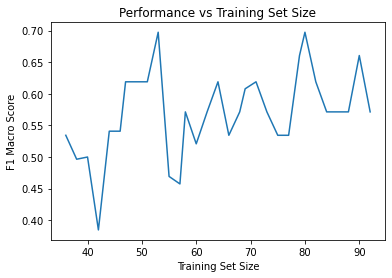

In [41]:
from matplotlib import pyplot as plt

plt.plot(x,y)
plt.title("Performance vs Training Set Size")
plt.ylabel("F1 Macro Score")
plt.xlabel("Training Set Size")
plt.show()

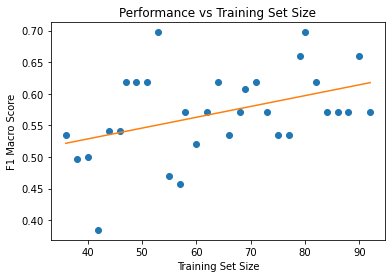

In [46]:
#from https://www.kite.com/python/answers/how-to-plot-a-linear-regression-line-on-a-scatter-plot-in-python

plt.plot(x, y, 'o')

m, b = np.polyfit(x, y, 1)
plt.title("Performance vs Training Set Size")
plt.ylabel("F1 Macro Score")
plt.xlabel("Training Set Size")
plt.plot(x, [m*xi + b for xi in x])
plt.show()